In [19]:
import pandas as pd
import numpy as np

from CudaSplines import GPUSpline,interpolation_point_inline

In [28]:
input = pd.read_csv('input_data.csv')
x_data = input['time'].values[::20]
y_data = input['low'].values[::20]

In [29]:
inter_x = np.sort(np.random.uniform(0,1300,(100000,100)),axis=1)

spline = GPUSpline(x_data,y_data)
inter_y = spline.eval(inter_x)

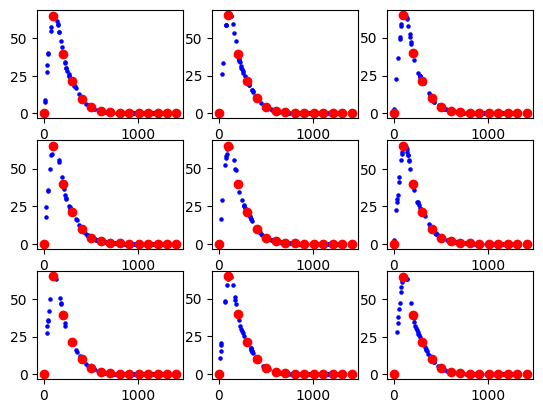

In [40]:
from numba import cuda
import matplotlib.pyplot as plt

@cuda.jit
def kernel(coef,x_array,y_array,int_pos):
    i = cuda.grid(1)
    if i < x_array.shape[0]:
        for k,dx in enumerate(x_array[i]):
            y_array[i,k] = interpolation_point_inline(coef,dx,int_pos[i])

tensor = spline.toTensor()
cuCoef = cuda.to_device(tensor)
cuInterX = cuda.to_device(inter_x)
inter_y = np.zeros_like(inter_x)
cuInterY = cuda.to_device(inter_y)
states = np.zeros(inter_x.shape[0],dtype=np.int64)
cuStates = cuda.to_device(states)

kernel[1000,100](cuCoef,cuInterX,cuInterY,cuStates)
cuda.synchronize()
inter_y = cuInterY.copy_to_host()

for i,(x,y) in enumerate(zip(inter_x[:9],inter_y[:9])):
    plt.subplot(3,3,i+1)
    plt.scatter(x,y,c='b',s=5)
    plt.scatter(x_data,y_data,c='r')
    
plt.show()